# Data Importing

In [1]:
# Import necessary modules

import numpy as np
import netCDF4 as nc
import pandas as pd

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline
from pathlib import Path
import glob
from functools import reduce
import calendar

from mpl_toolkits.basemap import Basemap, cm
import seaborn as sns 

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Import the station location data and station energy data

# Station data is the list of 98 Mesonet solar farm IDs, their location (longitude, latitude, elevation)
stations = pd.read_csv('station_info.csv')

# Energy data is the total daily energy availability on each day for each station
energy = pd.read_csv('train.csv', parse_dates=True, index_col='Date')

In [3]:
# Import the weather variable forecasts
# Forecasts are separated into 15 different files for each forecast variable (e.g. air pressure, specific humidity, etc.)
# Each variable is forecast using 11 different predictive models at 144 gridpoint locations
# (on 16 lines of longitude and 9 lines of latitude)

# Take any filename that ends in .nc and add to a list of the files
weather_file_list = glob.glob('*.nc')

# Take the data from each file in the file list and put into a list of data
list_of_data = [xr.open_dataset(filename) for filename in weather_file_list]

# Convert list of data to a list of dataframes
# Each dataframe consists of forecast data for a single weather variable
list_of_dfs = [data_file.to_dataframe() for data_file in list_of_data]

In [4]:
# Load previously organized data - includes energy availability for each day at each station and the associated weather
# variable forecasts
EDA_data = pd.read_csv('ML_dataset_filtered.csv')

In [5]:
def basic_oklahoma_map(ax=None, lllat=34, urlat=42,
                   lllon=-45, urlon=-75):
    '''
    Function for creating basemap object - adapted from: https://github.com/joelmpiper/solar_energy_prediction/blob/master/notebooks/slides/FinalPresentation.ipynb
    '''
    m = Basemap(ax=ax, projection='stere', lon_0=(urlon + lllon)/2,
               lat_0=(urlat + lllat) / 2, llcrnrlat = lllat, urcrnrlat=urlat,
               llcrnrlon=lllon, urcrnrlon=urlon,
               resolution='f')
    m.drawstates()
    return m

# Station Location and Elevation

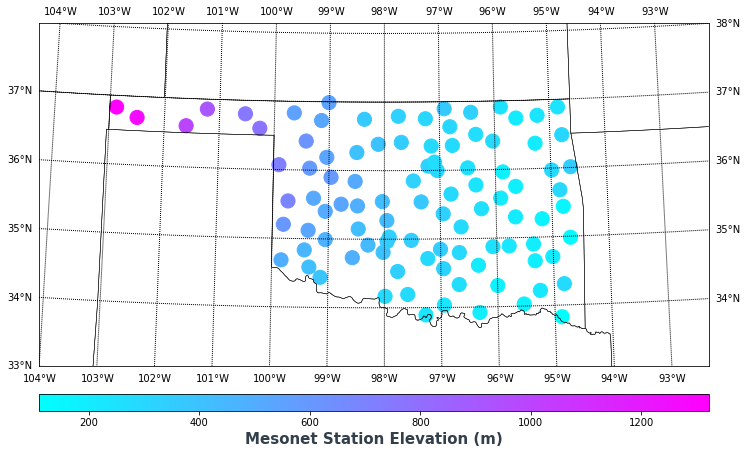

In [6]:
# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10)
meridians = np.arange(-104.,-92.,1.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10)

# Load station data (location and elevation)
data = stations['elev'].values
lons = stations['elon']
lats = stations['nlat']
x, y = m(lons.values, lats.values)

# Plot station locations coloured by elevation
cs = m.scatter(x,y, s=200, c=data, cmap='cool')

# Add colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Mesonet Station Elevation (m)', fontsize=15, fontweight='black', color = '#333F4B')

plt.show()

# Single Station Energy Availability

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


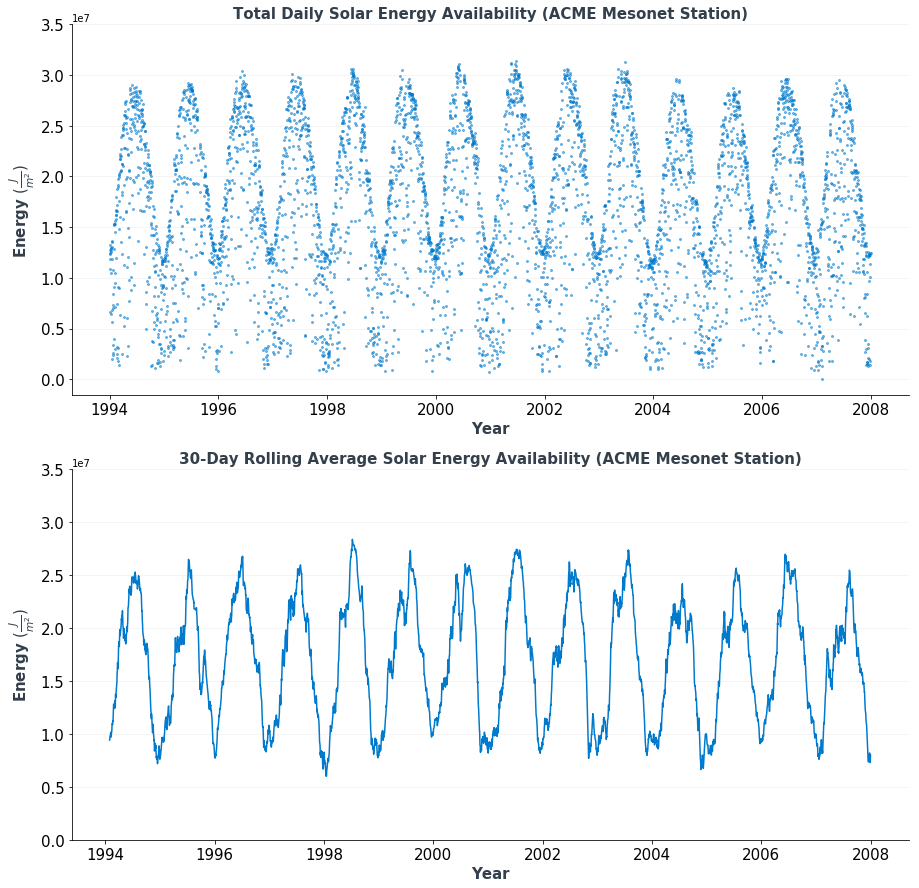

In [7]:
# Extract ACME energy data 
EDA_ACME = EDA_data[EDA_data['stid'] == 'ACME'].reset_index(drop=True)
del EDA_ACME['index']
EDA_ACME['Date'] = pd.to_datetime(EDA_ACME['Date'])

# Calculate the 30-day rolling average energy availability at ACME station
ACME_rolling = EDA_ACME.iloc[:,0:3]
del ACME_rolling['stid']
ACME_rolling = ACME_rolling.set_index('Date')
ACME_rolling['trailing_avg'] = ACME_rolling['energy'].rolling(window=30).mean()

# Initialize figure and axes
fig, ax = plt.subplots(2, 1, figsize=(15,15))

# Plot the daily energy availability 
ax[0].plot(EDA_ACME['Date'], EDA_ACME['energy'], "o", markersize=2, color='#007acc', alpha=0.5)

# Plot the 30-day rolling average energy availability
ax[1].plot(ACME_rolling['trailing_avg'], color='#007acc', alpha=1)

# Set titles
ax[0].set_title("Total Daily Solar Energy Availability (ACME Mesonet Station)", fontsize=15, fontweight='black', color = '#333F4B')
ax[1].set_title("30-Day Rolling Average Solar Energy Availability (ACME Mesonet Station)", fontsize=15, fontweight='black', color = '#333F4B')

# Set axis customizations
ind = np.arange(0, 40000000, 5000000)
for i in range(len(ax)):

    ax[i].set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
    ax[i].set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

    ax[i].set_facecolor('white')
    ax[i].grid(color='grey', alpha=0.1)
    ax[i].xaxis.grid(False)
    ax[i].set_axisbelow(True)
    
    ax[i].set_yticks(ind)
    ax[i].tick_params(labelsize=15)

    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')

plt.show()

# Combined Station Energy Availability

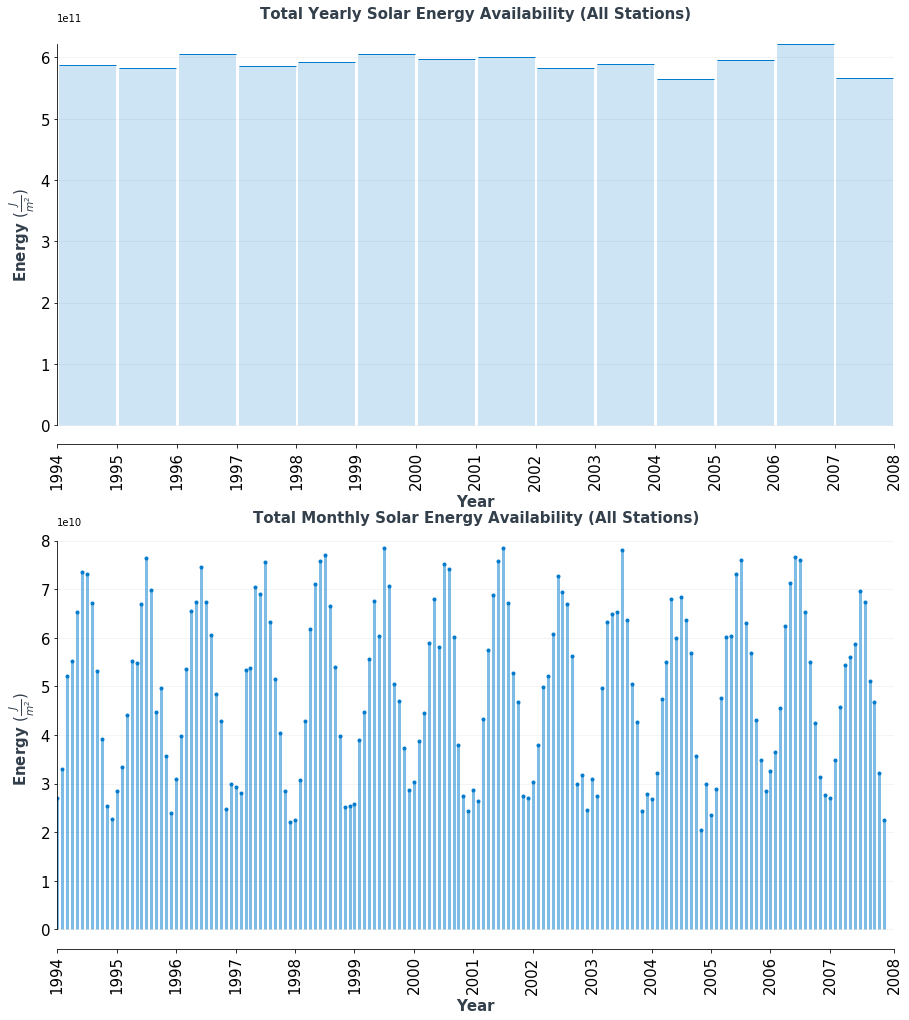

In [8]:
# Resample the energy data to sum for each year
total_energy_yearly = energy.resample('A').sum().sum(axis=1)

# Resample the energy data to sum for each month
total_energy_monthly = energy.resample('M').sum().sum(axis=1)

# Initialize figures and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,17))

# Initialize x locations and shift to the right to have the yearly bars line up with the years of the monthly chart
my_range=list(range(0,len(total_energy_yearly.index)))
my_range.append(14)
my_rangetemp = []
for i in range(len(my_range)):
    my_rangetemp.append(my_range[i] + 0.5)
    
# Plot bar lines for yearly data
ax1.vlines(x=my_rangetemp, ymin=0, ymax=total_energy_yearly, color='#007acc', alpha=0.2, linewidth=57)

# Use total_energy without extra value for lines at top of yearly bars
my_rangetemp.pop()

# Plot accent line at top of yearly bars
ax1.plot(my_rangetemp, total_energy_yearly, "_", markersize=57, color='#007acc', alpha=1)

# Initialize x locations for monthly data
my_range2=list(range(0,len(total_energy_monthly.index)))

# Plot bar lines for monthly data
ax2.vlines(x=my_range2, ymin=0, ymax=total_energy_monthly, color='#007acc', alpha=0.5, linewidth=3)

# Plot accent circle at top of monthly bars
ax2.plot(my_range2, total_energy_monthly, "o", markersize=3, color='#007acc', alpha=1)

# Set titles and axes labels
ax1.set_title("Total Yearly Solar Energy Availability (All Stations)", fontsize=15, fontweight='black', color = '#333F4B')
ax1.set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
ax1.set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

ax2.set_title("Total Monthly Solar Energy Availability (All Stations)", fontsize=15, fontweight='black', color = '#333F4B')
ax2.set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
ax2.set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

# Set axes customizations
ax1.set_facecolor('white')
ax2.set_facecolor('white')

ind = np.arange(len(total_energy_yearly)+1)
ax1.set_xticks(ind)
ax1.set_xticklabels(('1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008'), rotation=90, fontsize=15)

ax1.set_xlim(left = 0, right=14)
ax2.set_xlim(left = 0, right=14)

ind2 = np.arange(0, len(total_energy_monthly)+12, 12)
ind2[-1] = 169
ax2.set_xticks(ind2)
ax2.set_xticklabels(('1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008'), rotation=90, fontsize=15)

ax1.grid(color='grey', alpha=0.1)
ax1.xaxis.grid(False)
ax1.set_axisbelow(True)
ax2.grid(color='grey', alpha=0.1)
ax2.xaxis.grid(False)
ax2.set_axisbelow(True)

ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)

ax1.spines['top'].set_color('none')
ax1.spines['right'].set_color('none')
ax1.spines['left'].set_smart_bounds(True)
ax1.spines['bottom'].set_smart_bounds(True)

ax2.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['left'].set_smart_bounds(True)
ax2.spines['bottom'].set_smart_bounds(True)

plt.show()

# Energy Availability by Station

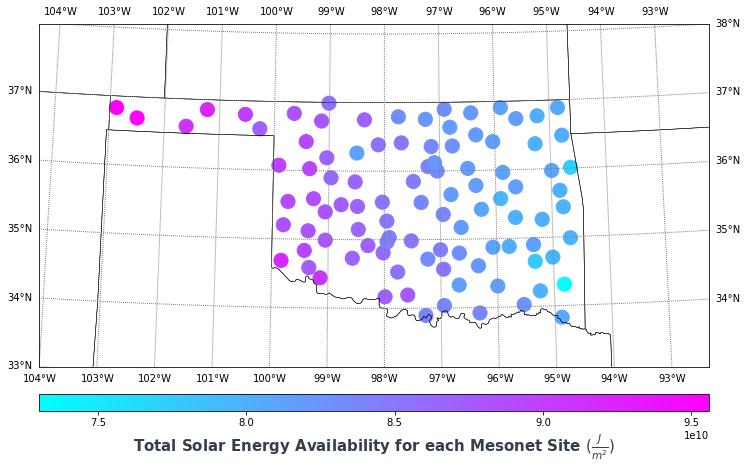

In [9]:
# Sum total energy availability of each station and merge with station info
energy_sum = EDA_data.groupby(by='stid').sum()['energy']
energy_sum = pd.merge(energy_sum, stations, on='stid')

# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10, color='grey')
meridians = np.arange(-104.,-92.,1.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10, color='grey')

# Load energy data and gridpoint locations
data = energy_sum['energy'].values
lons = energy_sum['elon']
lats = energy_sum['nlat']
x, y = m(lons.values, lats.values)

# Plot filled contours
cs = m.scatter(x,y, s=200, c=data, cmap='cool')

# Add colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Total Solar Energy Availability for each Mesonet Site $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

plt.show()

# East - West Stations Comparison

In [10]:
# Split stations at 98 deg W line of longitude
energy_sum_east = EDA_data[EDA_data['elon'] > 262]
del energy_sum_east['index']
energy_sum_east = energy_sum_east.set_index(pd.DatetimeIndex(energy_sum_east['Date']))

energy_sum_west = EDA_data[EDA_data['elon'] < 262]
del energy_sum_west['index']
energy_sum_west = energy_sum_west.set_index(pd.DatetimeIndex(energy_sum_west['Date']))

# Resample the energy data to average the east/west stations for each year
energy_sum_east = energy_sum_east.resample('A').mean()['energy']
energy_sum_west = energy_sum_west.resample('A').mean()['energy']

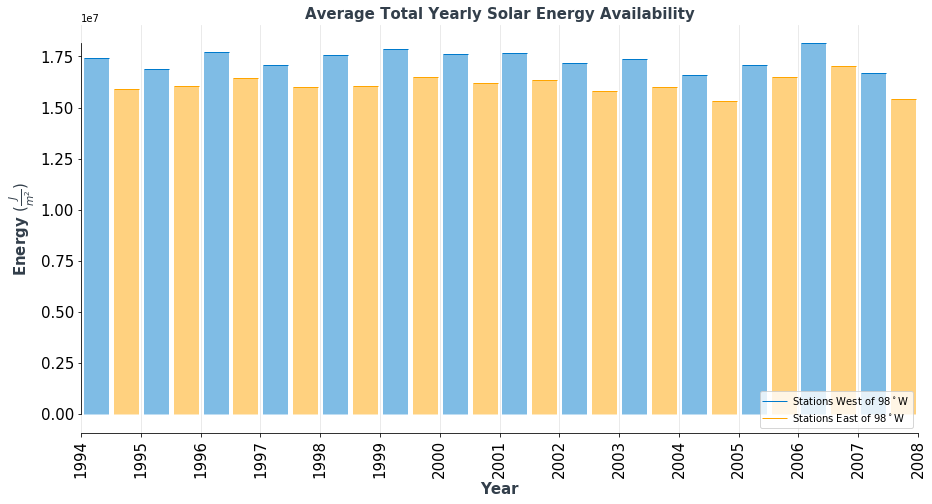

In [11]:
# Initialize figures and axes
fig, ax = plt.subplots(figsize=(15,7.5))

# Initialize x locations for west data
my_range=list(range(0,len(energy_sum_east.index)))
for i in range(len(my_range)):
    my_range[i] = my_range[i] + 0.25
    
# Plot bar lines for west data
ax.vlines(x=my_range, ymin=0, ymax=energy_sum_west, color='#007acc', alpha=0.5, linewidth=25)

# Plot accent line at top of west bars
ax.plot(my_range, energy_sum_west, "_", markersize=25, color='#007acc', alpha=1)

# Initialize x locations for east data
my_range2 = []
for i in range(len(my_range)):
    my_range2.append(my_range[i] + 0.5)

# Plot bar lines for east data
ax.vlines(x=my_range2, ymin=0, ymax=energy_sum_east, color='orange', alpha=0.5, linewidth=25)

# Plot accent circle at top of east bars
ax.plot(my_range2, energy_sum_east, "_", markersize=25, color='orange', alpha=1)

# Set titles and axes labels
ax.set_title("Average Total Yearly Solar Energy Availability", fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

# Set axes customizations
ax.set_facecolor('white')

ind = np.arange(len(total_energy_yearly)+1)
ax.set_xticks(ind)
ax.set_xticklabels(('1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008'), rotation=90, fontsize=15)

ax.set_xlim(left = 0, right=14)

ax.grid(color='grey', alpha=0.2)
ax.yaxis.grid(False)
ax.set_axisbelow(True)

ax.tick_params(labelsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

ax.legend(('Stations West of 98$^\circ$W', 'Stations East of 98$^\circ$W'), loc='lower right')

plt.show()

In [12]:
# East-west energy availability distributions

# Extract station energy data east of 98 deg W
energy_east = EDA_data[EDA_data['elon'] > 262]
energy_east = energy_east.set_index(pd.DatetimeIndex(energy_east['Date']))
del energy_east['index']
del energy_east['Date']
energy_east = energy_east.iloc[:,0:2].reset_index()
energy_east['year'] = energy_east.Date.apply(lambda x: x.strftime('%Y'))
del energy_east['Date']
del energy_east['stid']
energy_east['split'] = 'East of 49W'

# Extract station energy data west of 98 deg W
energy_west = EDA_data[EDA_data['elon'] < 262]
energy_west = energy_west.set_index(pd.DatetimeIndex(energy_west['Date']))
del energy_west['index']
del energy_west['Date']
energy_west = energy_west.iloc[:,0:2].reset_index()
energy_west['year'] = energy_west.Date.apply(lambda x: x.strftime('%Y'))
del energy_west['Date']
del energy_west['stid']
energy_west['split'] = 'West of 49W'

# Combine into single DataFrame
energy_split = pd.concat([energy_west, energy_east])

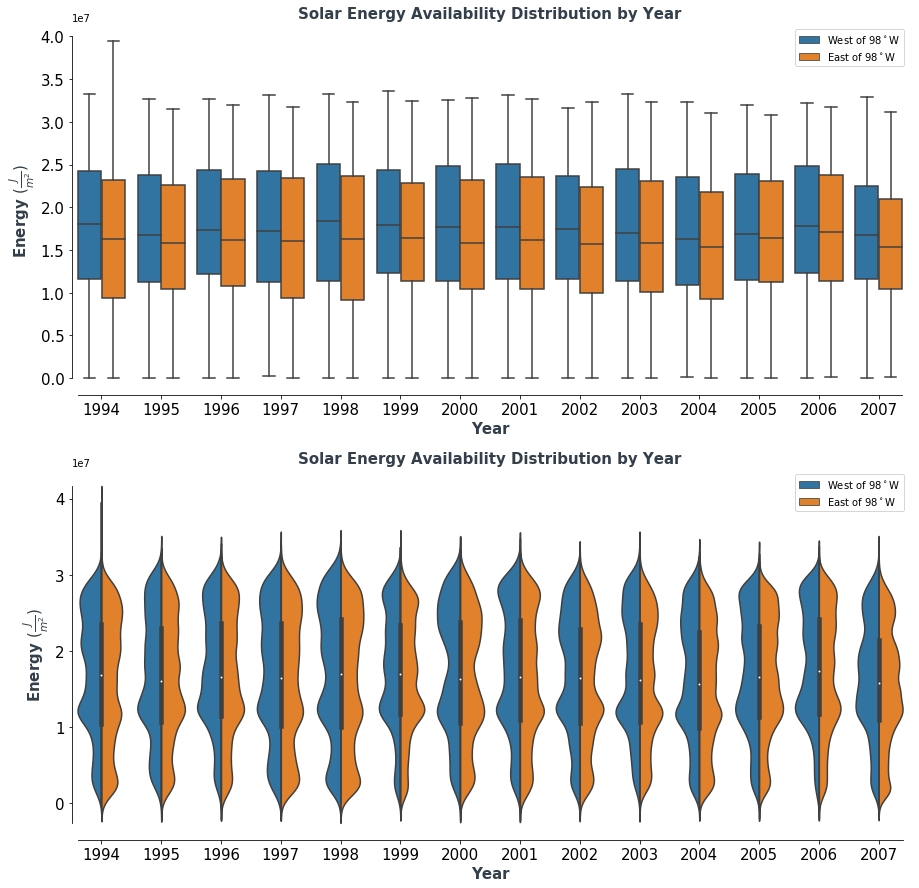

In [13]:
# Initialize figures and axes
fig, ax = plt.subplots(2, 1, figsize=(15,15))

# Plot boxplot
sns.boxplot(ax=ax[0], y='energy', x='year', hue='split', data=energy_split)

# Plot violinplot
sns.violinplot(ax=ax[1], y='energy', x='year', hue='split', data=energy_split, split=True)

# Set axes customizations
for i in range(len(ax)):
    
    ax[i].set_title("Solar Energy Availability Distribution by Year", fontsize=15, fontweight='black', color = '#333F4B')
    ax[i].set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
    ax[i].set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

    legend = ax[i].legend()
    legend.texts[0].set_text("West of 98$^\circ$W")
    legend.texts[1].set_text("East of 98$^\circ$W")

    ax[i].tick_params(labelsize=15)

    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')
    ax[i].spines['left'].set_smart_bounds(True)
    ax[i].spines['bottom'].set_smart_bounds(True)

plt.show()

# Weather Forecast Variables

In [14]:
# Total forecast precipitation (1994-2007)

# Load weather forecast data
total_prec = pd.DataFrame(list_of_dfs[0])
total_prec = total_prec.iloc[:, 2]
total_prec = total_prec.reset_index().set_index('time')

# Take the median of the 11 predictive models
total_prec = total_prec.groupby(by=['time','fhour', 'lat', 'lon']).median()
del total_prec['ens']

# Take the average value at each gridpoint
total_prec = total_prec.groupby(by=['lat', 'lon']).sum()
total_prec = total_prec.reset_index()

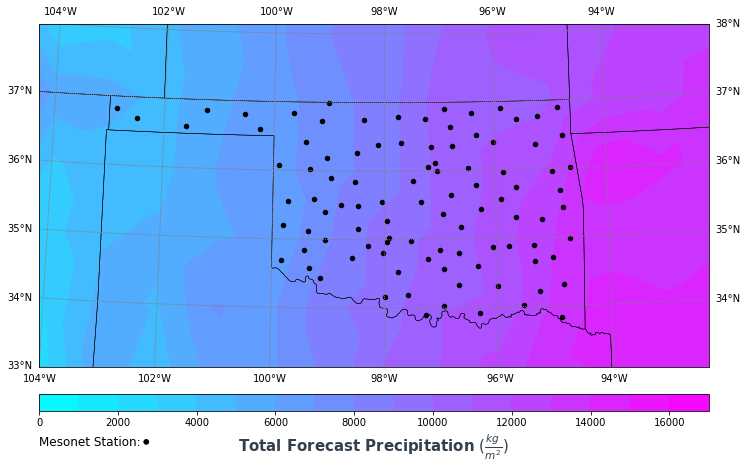

In [15]:
# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10, color='grey')
meridians = np.arange(-104.,-92.,2.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10, color='grey')

# Load weather forecast data and gridpoint locations
data = total_prec['Total_precipitation'].values
lons = total_prec['lon']
lats = total_prec['lat']
x, y = m(lons.values, lats.values)

# Plot filled contours
clevs = range(0,18000,1000)
cs = plt.tricontourf(x,y,data,clevs,cmap='cool')

# Add colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Total Forecast Precipitation $(\frac{kg}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

# Plot the station locations
stat_lons = stations['elon']
stat_lats = stations['nlat']
x2, y2 = m(stat_lons.values, stat_lats.values)
cs2 = m.scatter(x2,y2, s=20, color='black')

# Add station legend
plt.text(0.125,0.185, r'Mesonet Station:', fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.24,0.185, r'$\bullet$', fontsize=20, transform=plt.gcf().transFigure)

plt.show()

In [16]:
# Total forecast downward short-wave radiative flux (1994-2007)

# Load weather forecast data
total_shortwave_rad = pd.DataFrame(list_of_dfs[2])
total_shortwave_rad = total_shortwave_rad.iloc[:, 2]
total_shortwave_rad = total_shortwave_rad.reset_index().set_index('time')

# Take the median of the 11 predictive models
total_shortwave_rad = total_shortwave_rad.groupby(by=['time','fhour', 'lat', 'lon']).median()
del total_shortwave_rad['ens']

# Take the total value at each gridpoint
total_shortwave_rad = total_shortwave_rad.groupby(by=['lat', 'lon']).sum()
total_shortwave_rad = total_shortwave_rad.reset_index()

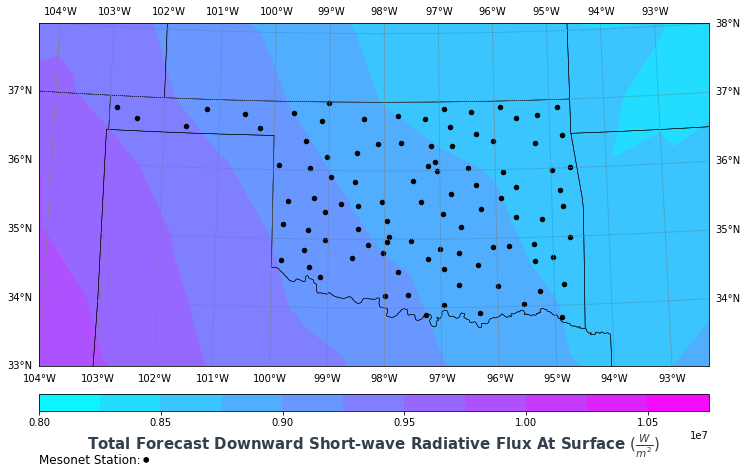

In [17]:
# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10, color='grey')
meridians = np.arange(-104.,-92.,1.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10, color='grey')

# Load weather forecast data and gridpoint locations
data = total_shortwave_rad['Downward_Short-Wave_Rad_Flux'].values
lons = total_shortwave_rad['lon']
lats = total_shortwave_rad['lat']
x, y = m(lons.values, lats.values)

# Plot filled contours
clevs = range(8000000,11000000,250000)
cs = plt.tricontourf(x,y,data,clevs,cmap='cool')

# Add colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Total Forecast Downward Short-wave Radiative Flux At Surface $(\frac{W}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

# Plot the station locations
stat_lons = stations['elon']
stat_lats = stations['nlat']
x2, y2 = m(stat_lons.values, stat_lats.values)
cs2 = m.scatter(x2,y2, s=20, color='black')

# Add station legend
plt.text(0.125,0.16, r'Mesonet Station:', fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.24,0.16, r'$\bullet$', fontsize=20, transform=plt.gcf().transFigure)

plt.show()

In [18]:
# Average forecast cloud cover percentage (1994-2007)

# Load weather forecast data
avg_cloud_cover = pd.DataFrame(list_of_dfs[6])
avg_cloud_cover = avg_cloud_cover.iloc[:, 2]
avg_cloud_cover = avg_cloud_cover.reset_index().set_index('time')

# Take the median of the 11 predictive models
avg_cloud_cover = avg_cloud_cover.groupby(by=['time','fhour', 'lat', 'lon']).median()
del avg_cloud_cover['ens']

# Take the average value at each gridpoint
avg_cloud_cover = avg_cloud_cover.groupby(by=['lat', 'lon']).mean()
avg_cloud_cover = avg_cloud_cover.reset_index()

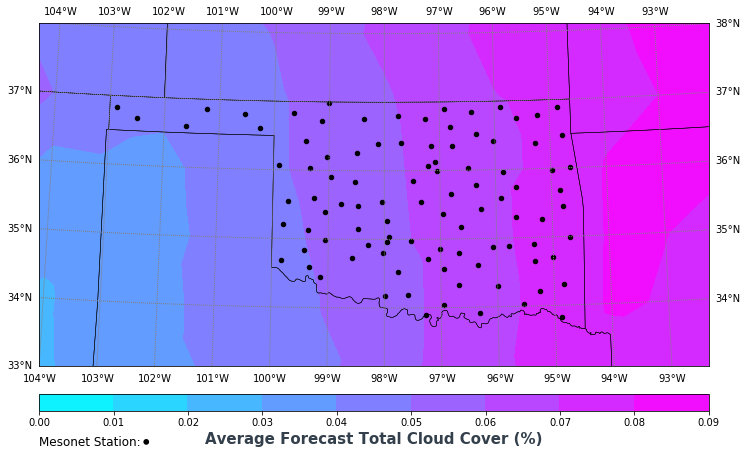

In [19]:
# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10, color='grey')
meridians = np.arange(-104.,-92.,1.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10, color='grey')

# Load weather forecast data and gridpoint locations
data = avg_cloud_cover['Total_cloud_cover'].values
lons = avg_cloud_cover['lon']
lats = avg_cloud_cover['lat']
x, y = m(lons.values, lats.values)

# Plot filled contours
clevs = np.arange(0,0.1,0.01)
cs = plt.tricontourf(x,y,data,clevs,cmap='cool')

# Add colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Average Forecast Total Cloud Cover (%)', fontsize=15, fontweight='black', color = '#333F4B')

# Plot the station locations
stat_lons = stations['elon']
stat_lats = stations['nlat']
x2, y2 = m(stat_lons.values, stat_lats.values)
cs2 = m.scatter(x2,y2, s=20, color='black')

# Add station legend
plt.text(0.125,0.185, r'Mesonet Station:', fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.24,0.185, r'$\bullet$', fontsize=20, transform=plt.gcf().transFigure)

plt.show()

In [20]:
# Average forecast surface temperature (1994-2007)

# Load weather forecast data
avg_temp = pd.DataFrame(list_of_dfs[11])
avg_temp = avg_temp.iloc[:, 2]
avg_temp = avg_temp.reset_index().set_index('time')

# Take the median of the 11 predictive models
avg_temp = avg_temp.groupby(by=['time','fhour', 'lat', 'lon']).median()
del avg_temp['ens']

# Take the average value at each gridpoint
avg_temp = avg_temp.groupby(by=['lat', 'lon']).mean()
avg_temp = avg_temp.reset_index()

# Convert kelvin to deg. celcius 
avg_temp['Temperature_surface'] = avg_temp['Temperature_surface'] - 273.15

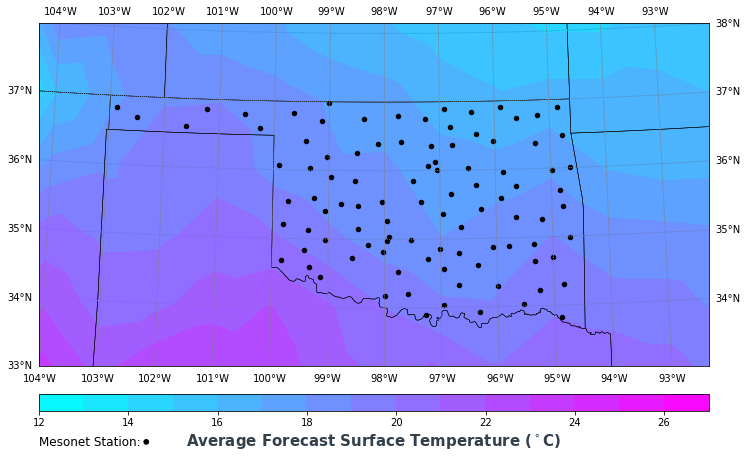

In [21]:
# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10, color='grey')
meridians = np.arange(-104.,-92.,1.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10, color='grey')

# Load weather forecast data and gridpoint locations
data = avg_temp['Temperature_surface'].values
lons = avg_temp['lon']
lats = avg_temp['lat']
x, y = m(lons.values, lats.values)

# Plot filled contours
clevs = range(12,28,1)
cs = plt.tricontourf(x,y,data,clevs,cmap='cool')

# Add colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Average Forecast Surface Temperature ($^\circ$C)', fontsize=15, fontweight='black', color = '#333F4B')

# Plot the station locations
stat_lons = stations['elon']
stat_lats = stations['nlat']
x2, y2 = m(stat_lons.values, stat_lats.values)
cs2 = m.scatter(x2,y2, s=20, color='black')

# Add station legend
plt.text(0.125,0.185, r'Mesonet Station:', fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.24,0.185, r'$\bullet$', fontsize=20, transform=plt.gcf().transFigure)

plt.show()